In [1]:
import json
import os
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
import warnings

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
assert os.cpu_count() == 96

In [3]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [4]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [5]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = (
    "experiments/autocorrelation/N256_metropolis_hastings/experiment.ipynb"
)
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "cpu"
ALGORITHM = "metropolis_hastings"
DIMENSIONS = 2
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 64
N_SAMPLES_VECTORISE = 4
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 100
TEMP_MIN = 0.9
TEMP_MAX = 1.4
DO_AUTOCORRELATION = True
DO_MEASURE = False
PLOT_STATES = False
SIZE = 256

In [6]:
# TPU + high dim
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES = N_TEMPS * 4
#     LOOP_N_TEMPS_Y = True
#     N_SAMPLES_VECTORISE = 1

# DIMENSIONS = 4
# SIZE = 32

# TEMP_MIN = 6.0 / 2
# TEMP_MAX = 6.8 / 2

# THERMALISE_STEPS: int = 100
# THERMALISE_SWEEPS_PER_STEP: int = 100

In [7]:
# # CPU + Quick
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.CPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 96 * 2
#     TOTAL_SAMPLES = 96 * 2 * 2 * 2
#     LOOP_N_TEMPS_Y = False
#     N_SAMPLES_VECTORISE = 2

#     DIMENSIONS = 2
#     SIZE = 32

#     # TEMP_MIN = 6.0 / 2
#     # TEMP_MAX = 6.8 / 2

#     THERMALISE_STEPS: int = 25
#     THERMALISE_SWEEPS_PER_STEP: int = 100

In [8]:
# if not PAPERMILL:
#     ...
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES: int = 128
#     N_SAMPLES_VECTORISE = 1

#     DIMENSIONS = 3

#     # TEMP_MIN = 2.1
#     # TEMP_MAX = 2.7
#     SIZE = 64
#     TOTAL_SAMPLES = N_TEMPS
# TEMP_MIN = 6.0
# TEMP_MAX = 6.8

In [9]:
#! Papermill-like
if not PAPERMILL:
    # PAPERMILL = True
    RNG_SEED = 1
    JAX_PLATFORM = JaxPlatform.TPU
    ALGORITHM = AlgorithmChoice.WOLFF
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 96 * 4
    N_TEMPS = 96
    N_SAMPLES_VECTORISE = 4
    THERMALISE_STEPS = 100
    # THERMALISE_SWEEPS_PER_STEP = 250
    DO_AUTOCORRELATION = True
    TEMP_MIN = 0.4
    TEMP_MAX = 3.0
    SIZE = 64

In [10]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "cpu"
    ALGORITHM = "metropolis_hastings"
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 96 * 4
    N_TEMPS = 96
    N_SAMPLES_VECTORISE = 4
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 100
    TEMP_MIN = 1.1
    TEMP_MAX = 1.2
    DO_AUTOCORRELATION = False
    DO_MEASURE = False
    AUTOCORRELATION_STEPS: int = 2500
    AUTOCORRELATION_SWEEPS_PER_STEP: int = 2
    SIZE = 32

In [11]:
Path().resolve()

PosixPath('/home/jeppe/Jackpot')

In [12]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

SAVE_PATH=PosixPath('/home/jeppe/Jackpot/experiments/autocorrelation/N256_metropolis_hastings')


In [13]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 64
c.n_temps=64
N_TEMPS_X=64
N_TEMPS_Y=1
N_SAMPLES_PER_TEMP=4
--c.n_samples_vectorise=4
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 2_560_000


/tmp/ipykernel_243176/566678328.py:21: UserWarning: Should have at least 96 temperatures for maximum throughput
  warnings.warn(


In [14]:
# Single state
model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=c.dimensions,
    size=c.size,
    beta=1.0,
    model=model,
    algorithm=algorithm,
    id_=0,
)

initial_state = state

state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
measured = state.measure()

state.calculate_energy()
state.calculate_magnetisation_density()

Array(0.00483704, dtype=float32)

# Thermalisation

In [15]:
from jackpot.models.base import Model


@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 5

# print(
#         state_keys,
#     c.spin,
#     c.dimensions,
#     c.size,
#     _betas,
#     ids,
#     c.thermalise_steps,
#     c.thermalise_sweeps_per_step,
#     MODEL_BASE_PARAMS,
#     c.algorithm,
#     thermalise_num_prints,
# )
thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 64, 1, 4)


/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 5.413147687911987 sec.


  0%|                                                         | 0/6400 [00:00<?, ?it/s]

  0%|                                                | 10/6400 [00:00<01:16, 83.36it/s]

  1%|▎                                              | 40/6400 [00:00<00:31, 200.30it/s]

  1%|▍                                              | 64/6400 [00:19<00:31, 200.30it/s]

  1%|▌                                             | 84/6400 [05:54<8:53:16,  5.07s/it]

  2%|▋                                            | 104/6400 [05:56<6:21:32,  3.64s/it]

  2%|▊                                            | 124/6400 [05:57<4:29:47,  2.58s/it]

  3%|█▏                                           | 164/6400 [05:57<2:26:20,  1.41s/it]

  3%|█▎                                           | 184/6400 [05:58<1:51:00,  1.07s/it]

  3%|█▍                                           | 204/6400 [05:58<1:22:19,  1.25it/s]

  4%|█▌                                           | 224/6400 [05:59<1:00:01,  1.71it/s]

  4%|██                                             | 284/6400 [05:59<27:42,  3.68it/s]

  5%|██▏                                            | 304/6400 [05:59<22:26,  4.53it/s]

  6%|██▋                                            | 364/6400 [06:00<12:08,  8.29it/s]

  6%|██▊                                            | 384/6400 [06:00<10:01, 10.00it/s]

  6%|██▉                                            | 404/6400 [06:00<08:11, 12.20it/s]

  7%|███▎                                           | 444/6400 [06:00<05:18, 18.72it/s]

  8%|███▌                                           | 484/6400 [06:01<03:50, 25.64it/s]

  8%|███▋                                           | 504/6400 [06:01<03:17, 29.80it/s]

  8%|███▉                                           | 544/6400 [06:01<02:12, 44.32it/s]

  9%|████▏                                          | 564/6400 [06:01<01:52, 52.03it/s]

  9%|████▎                                          | 584/6400 [06:01<01:43, 56.09it/s]

 10%|████▌                                          | 624/6400 [06:02<01:16, 75.57it/s]

 10%|████▋                                          | 644/6400 [06:02<01:25, 67.48it/s]

 10%|████▉                                          | 664/6400 [06:02<01:23, 68.89it/s]

 11%|█████▏                                         | 704/6400 [06:03<01:11, 79.98it/s]

 11%|█████▎                                         | 724/6400 [06:03<01:22, 69.11it/s]

 12%|█████▍                                         | 744/6400 [06:03<01:25, 66.51it/s]

 13%|█████▊                                        | 804/6400 [06:04<00:52, 106.52it/s]

 13%|█████▉                                        | 824/6400 [06:04<00:52, 105.41it/s]

 14%|██████▏                                       | 864/6400 [06:04<00:47, 116.73it/s]

 14%|██████▍                                       | 904/6400 [06:04<00:38, 141.05it/s]

 14%|██████▋                                       | 924/6400 [06:04<00:36, 148.37it/s]

 15%|██████▊                                       | 944/6400 [06:05<00:35, 154.77it/s]

 15%|███████                                        | 964/6400 [06:05<00:54, 99.60it/s]

 15%|███████▏                                       | 984/6400 [06:05<00:57, 93.64it/s]

 16%|███████                                      | 1004/6400 [06:05<00:51, 104.39it/s]

 16%|███████▎                                      | 1024/6400 [06:06<01:18, 68.45it/s]

 17%|███████▋                                      | 1064/6400 [06:06<01:12, 73.15it/s]

 17%|███████▉                                      | 1104/6400 [06:07<00:55, 95.07it/s]

 18%|████████                                      | 1124/6400 [06:07<00:55, 95.68it/s]

 18%|████████▏                                     | 1144/6400 [06:07<01:14, 70.31it/s]

 18%|████████▎                                     | 1164/6400 [06:08<01:09, 75.74it/s]

 18%|████████▌                                     | 1184/6400 [06:08<01:03, 82.42it/s]

 19%|████████▋                                     | 1204/6400 [06:08<01:04, 80.91it/s]

 19%|████████▊                                     | 1224/6400 [06:08<01:02, 82.73it/s]

 19%|████████▉                                     | 1244/6400 [06:09<01:07, 75.85it/s]

 20%|█████████                                     | 1264/6400 [06:09<01:23, 61.75it/s]

 20%|█████████▏                                    | 1284/6400 [06:09<01:07, 75.35it/s]

 20%|█████████▎                                    | 1304/6400 [06:11<02:34, 32.89it/s]

 21%|█████████▌                                    | 1324/6400 [06:11<02:18, 36.65it/s]

 21%|█████████▋                                    | 1344/6400 [06:12<03:29, 24.08it/s]

 21%|█████████▋                                    | 1344/6400 [06:30<03:29, 24.08it/s]

 21%|█████████▍                                  | 1364/6400 [11:51<7:06:16,  5.08s/it]

 22%|█████████▌                                  | 1384/6400 [11:55<5:02:33,  3.62s/it]

 22%|█████████▋                                  | 1404/6400 [11:56<3:32:47,  2.56s/it]

 22%|█████████▊                                  | 1424/6400 [11:57<2:29:11,  1.80s/it]

 23%|█████████▉                                  | 1444/6400 [11:57<1:44:18,  1.26s/it]

 23%|██████████                                  | 1464/6400 [11:57<1:13:18,  1.12it/s]

 23%|██████████▋                                   | 1484/6400 [11:58<51:23,  1.59it/s]

 24%|██████████▊                                   | 1504/6400 [11:58<36:04,  2.26it/s]

 24%|██████████▉                                   | 1524/6400 [11:58<25:16,  3.21it/s]

 24%|███████████                                   | 1544/6400 [11:58<17:56,  4.51it/s]

 24%|███████████▏                                  | 1564/6400 [12:00<14:42,  5.48it/s]

 25%|███████████▍                                  | 1584/6400 [12:00<10:24,  7.72it/s]

 25%|███████████▌                                  | 1604/6400 [12:01<07:54, 10.10it/s]

 25%|███████████▋                                  | 1624/6400 [12:01<05:52, 13.57it/s]

 27%|████████████▍                                 | 1724/6400 [12:01<01:59, 39.08it/s]

 28%|████████████▊                                 | 1784/6400 [12:01<01:18, 58.45it/s]

 28%|█████████████                                 | 1824/6400 [12:02<01:11, 64.17it/s]

 29%|█████████████▎                                | 1844/6400 [12:02<01:08, 66.96it/s]

 29%|█████████████▍                                | 1864/6400 [12:03<01:17, 58.53it/s]

 29%|█████████████▌                                | 1884/6400 [12:03<01:21, 55.73it/s]

 30%|█████████████▋                                | 1904/6400 [12:03<01:25, 52.88it/s]

 30%|█████████████▊                                | 1924/6400 [12:04<01:15, 59.40it/s]

 31%|██████████████                                | 1964/6400 [12:04<00:51, 86.52it/s]

 31%|██████████████▎                               | 1984/6400 [12:05<01:20, 54.70it/s]

 32%|██████████████▌                               | 2024/6400 [12:05<00:58, 75.42it/s]

 32%|██████████████▊                               | 2064/6400 [12:06<01:27, 49.47it/s]

 33%|██████████████▉                               | 2084/6400 [12:06<01:20, 53.77it/s]

 33%|███████████████▎                              | 2124/6400 [12:07<00:57, 74.16it/s]

 34%|███████████████▍                              | 2144/6400 [12:07<01:07, 63.14it/s]

 34%|███████████████▋                              | 2184/6400 [12:07<00:48, 86.07it/s]

 34%|███████████████▊                              | 2204/6400 [12:08<00:49, 85.25it/s]

 35%|███████████████▉                              | 2224/6400 [12:09<02:04, 33.51it/s]

 35%|████████████████▏                             | 2244/6400 [12:10<01:47, 38.56it/s]

 35%|████████████████▎                             | 2264/6400 [12:10<02:05, 33.02it/s]

 36%|████████████████▌                             | 2304/6400 [12:11<01:19, 51.42it/s]

 36%|████████████████▋                             | 2324/6400 [12:11<01:20, 50.58it/s]

 37%|████████████████▊                             | 2344/6400 [12:12<01:27, 46.58it/s]

 37%|████████████████▉                             | 2364/6400 [12:12<01:18, 51.34it/s]

 37%|█████████████████▏                            | 2384/6400 [12:13<01:47, 37.35it/s]

 38%|█████████████████▍                            | 2424/6400 [12:14<01:38, 40.49it/s]

 38%|█████████████████▋                            | 2464/6400 [12:14<01:27, 45.04it/s]

 39%|█████████████████▊                            | 2484/6400 [12:15<01:31, 42.92it/s]

 39%|█████████████████▉                            | 2504/6400 [12:16<01:44, 37.30it/s]

 39%|██████████████████▏                           | 2524/6400 [12:17<02:27, 26.27it/s]

 40%|██████████████████▎                           | 2544/6400 [12:18<02:24, 26.70it/s]

 40%|██████████████████▍                           | 2564/6400 [12:18<02:06, 30.30it/s]

 40%|██████████████████▌                           | 2584/6400 [12:20<03:09, 20.12it/s]

 41%|██████████████████▋                           | 2604/6400 [12:20<02:23, 26.45it/s]

 41%|██████████████████▊                           | 2624/6400 [12:25<06:02, 10.42it/s]

 41%|██████████████████▊                           | 2624/6400 [12:40<06:02, 10.42it/s]

 41%|██████████████████▏                         | 2644/6400 [17:53<5:05:14,  4.88s/it]

 42%|██████████████████▎                         | 2664/6400 [17:53<3:34:25,  3.44s/it]

 42%|██████████████████▍                         | 2684/6400 [17:54<2:30:28,  2.43s/it]

 42%|██████████████████▌                         | 2704/6400 [17:54<1:45:22,  1.71s/it]

 43%|██████████████████▋                         | 2724/6400 [17:55<1:14:09,  1.21s/it]

 43%|███████████████████▋                          | 2744/6400 [17:56<52:26,  1.16it/s]

 43%|███████████████████▊                          | 2764/6400 [17:57<37:48,  1.60it/s]

 44%|████████████████████▎                         | 2824/6400 [17:57<16:23,  3.64it/s]

 44%|████████████████████▍                         | 2844/6400 [17:58<13:37,  4.35it/s]

 45%|████████████████████▌                         | 2864/6400 [18:00<11:13,  5.25it/s]

 45%|████████████████████▊                         | 2904/6400 [18:00<06:53,  8.46it/s]

 46%|█████████████████████                         | 2924/6400 [18:01<06:09,  9.40it/s]

 46%|█████████████████████▎                        | 2964/6400 [18:02<03:59, 14.34it/s]

 47%|█████████████████████▍                        | 2984/6400 [18:02<03:16, 17.35it/s]

 47%|█████████████████████▌                        | 3004/6400 [18:02<02:39, 21.23it/s]

 47%|█████████████████████▋                        | 3024/6400 [18:02<02:03, 27.39it/s]

 48%|█████████████████████▉                        | 3044/6400 [18:03<01:40, 33.33it/s]

 48%|██████████████████████                        | 3064/6400 [18:04<01:57, 28.32it/s]

 48%|██████████████████████▎                       | 3104/6400 [18:04<01:12, 45.45it/s]

 49%|██████████████████████▍                       | 3124/6400 [18:04<01:08, 47.60it/s]

 49%|██████████████████████▌                       | 3144/6400 [18:05<01:22, 39.27it/s]

 50%|██████████████████████▉                       | 3184/6400 [18:05<01:01, 52.28it/s]

 50%|███████████████████████▏                      | 3224/6400 [18:06<00:52, 60.74it/s]

 51%|███████████████████████▍                      | 3264/6400 [18:06<00:46, 67.36it/s]

 51%|███████████████████████▌                      | 3284/6400 [18:07<00:59, 52.46it/s]

 52%|███████████████████████▉                      | 3324/6400 [18:07<00:45, 67.99it/s]

 52%|████████████████████████                      | 3344/6400 [18:07<00:40, 76.25it/s]

 53%|████████████████████████▏                     | 3364/6400 [18:10<01:49, 27.65it/s]

 53%|████████████████████████▎                     | 3384/6400 [18:11<02:17, 21.88it/s]

 54%|████████████████████████▌                     | 3424/6400 [18:13<02:10, 22.85it/s]

 54%|████████████████████████▊                     | 3444/6400 [18:13<01:43, 28.47it/s]

 54%|████████████████████████▉                     | 3464/6400 [18:14<01:51, 26.43it/s]

 54%|█████████████████████████                     | 3484/6400 [18:14<01:36, 30.27it/s]

 55%|█████████████████████████▎                    | 3524/6400 [18:14<00:58, 48.88it/s]

 55%|█████████████████████████▍                    | 3544/6400 [18:15<00:52, 54.29it/s]

 56%|█████████████████████████▌                    | 3564/6400 [18:16<01:18, 35.97it/s]

 56%|█████████████████████████▊                    | 3584/6400 [18:16<01:03, 44.08it/s]

 56%|█████████████████████████▉                    | 3604/6400 [18:16<00:50, 55.81it/s]

 57%|██████████████████████████                    | 3624/6400 [18:16<00:46, 59.66it/s]

 57%|██████████████████████████▏                   | 3644/6400 [18:17<00:42, 64.10it/s]

 57%|██████████████████████████▎                   | 3664/6400 [18:19<01:45, 25.84it/s]

 58%|██████████████████████████▍                   | 3684/6400 [18:19<01:25, 31.72it/s]

 58%|██████████████████████████▌                   | 3704/6400 [18:19<01:11, 37.75it/s]

 58%|██████████████████████████▊                   | 3724/6400 [18:22<02:26, 18.28it/s]

 59%|███████████████████████████                   | 3764/6400 [18:24<02:16, 19.24it/s]

 59%|███████████████████████████▏                  | 3784/6400 [18:24<02:02, 21.40it/s]

 59%|███████████████████████████▎                  | 3804/6400 [18:29<04:06, 10.52it/s]

 60%|███████████████████████████▍                  | 3824/6400 [18:30<03:49, 11.22it/s]

 60%|███████████████████████████▋                  | 3844/6400 [18:31<03:07, 13.61it/s]

 60%|███████████████████████████▊                  | 3864/6400 [18:31<02:25, 17.38it/s]

 61%|███████████████████████████▉                  | 3884/6400 [18:33<03:02, 13.78it/s]

 61%|████████████████████████████                  | 3904/6400 [18:39<05:22,  7.75it/s]

 61%|████████████████████████████                  | 3904/6400 [18:50<05:22,  7.75it/s]

 61%|██████████████████████████▉                 | 3924/6400 [23:49<3:12:29,  4.66s/it]

 62%|███████████████████████████                 | 3944/6400 [23:50<2:14:44,  3.29s/it]

 62%|███████████████████████████▎                | 3964/6400 [23:51<1:34:26,  2.33s/it]

 62%|███████████████████████████▍                | 3984/6400 [23:52<1:06:40,  1.66s/it]

 63%|████████████████████████████▊                 | 4004/6400 [23:53<46:42,  1.17s/it]

 63%|████████████████████████████▉                 | 4024/6400 [23:55<33:36,  1.18it/s]

 63%|█████████████████████████████                 | 4044/6400 [23:55<23:29,  1.67it/s]

 64%|█████████████████████████████▏                | 4064/6400 [23:56<17:06,  2.28it/s]

 64%|█████████████████████████████▎                | 4084/6400 [23:57<12:31,  3.08it/s]

 64%|█████████████████████████████▋                | 4124/6400 [24:00<07:53,  4.81it/s]

 65%|█████████████████████████████▊                | 4144/6400 [24:01<06:13,  6.05it/s]

 65%|█████████████████████████████▉                | 4164/6400 [24:02<04:48,  7.75it/s]

 65%|██████████████████████████████                | 4184/6400 [24:02<03:34, 10.33it/s]

 66%|██████████████████████████████▏               | 4204/6400 [24:02<02:46, 13.21it/s]

 66%|██████████████████████████████▎               | 4224/6400 [24:03<02:11, 16.61it/s]

 66%|██████████████████████████████▌               | 4244/6400 [24:03<01:35, 22.49it/s]

 67%|██████████████████████████████▋               | 4264/6400 [24:03<01:22, 26.00it/s]

 67%|██████████████████████████████▊               | 4284/6400 [24:04<01:24, 24.97it/s]

 67%|██████████████████████████████▉               | 4304/6400 [24:04<01:10, 29.87it/s]

 68%|███████████████████████████████               | 4324/6400 [24:05<01:15, 27.44it/s]

 68%|███████████████████████████████▏              | 4344/6400 [24:06<01:04, 31.71it/s]

 68%|███████████████████████████████▎              | 4364/6400 [24:06<00:53, 38.26it/s]

 68%|███████████████████████████████▌              | 4383/6400 [24:06<00:41, 48.39it/s]

 69%|███████████████████████████████▋              | 4403/6400 [24:07<00:42, 47.48it/s]

 69%|███████████████████████████████▊              | 4423/6400 [24:07<00:35, 55.06it/s]

 70%|████████████████████████████████              | 4463/6400 [24:07<00:30, 63.16it/s]

 70%|████████████████████████████████▎             | 4502/6400 [24:08<00:26, 71.77it/s]

 71%|████████████████████████████████▍             | 4521/6400 [24:08<00:23, 80.01it/s]

 71%|████████████████████████████████▋             | 4541/6400 [24:08<00:22, 82.76it/s]

 71%|████████████████████████████████▊             | 4561/6400 [24:09<00:36, 49.76it/s]

 72%|████████████████████████████████▉             | 4580/6400 [24:10<01:01, 29.42it/s]

 72%|█████████████████████████████████▏            | 4619/6400 [24:11<00:40, 44.47it/s]

 72%|█████████████████████████████████▎            | 4639/6400 [24:11<00:38, 45.48it/s]

 73%|█████████████████████████████████▍            | 4659/6400 [24:11<00:38, 45.36it/s]

 73%|█████████████████████████████████▋            | 4679/6400 [24:12<00:35, 48.92it/s]

 73%|█████████████████████████████████▊            | 4699/6400 [24:12<00:40, 41.91it/s]

 74%|█████████████████████████████████▉            | 4719/6400 [24:13<00:34, 48.28it/s]

 74%|██████████████████████████████████            | 4738/6400 [24:13<00:32, 50.44it/s]

 74%|██████████████████████████████████▏           | 4757/6400 [24:13<00:30, 53.79it/s]

 75%|██████████████████████████████████▎           | 4777/6400 [24:14<00:25, 62.54it/s]

 75%|██████████████████████████████████▍           | 4796/6400 [24:14<00:33, 48.05it/s]

 75%|██████████████████████████████████▌           | 4816/6400 [24:14<00:27, 57.69it/s]

 76%|██████████████████████████████████▊           | 4835/6400 [24:15<00:26, 58.82it/s]

 76%|██████████████████████████████████▉           | 4855/6400 [24:15<00:22, 68.31it/s]

 76%|███████████████████████████████████           | 4874/6400 [24:15<00:20, 75.58it/s]

 76%|███████████████████████████████████▏          | 4894/6400 [24:16<00:35, 41.88it/s]

 77%|███████████████████████████████████▎          | 4914/6400 [24:17<00:56, 26.38it/s]

 77%|███████████████████████████████████▍          | 4934/6400 [24:18<00:46, 31.36it/s]

 77%|███████████████████████████████████▌          | 4953/6400 [24:18<00:39, 36.57it/s]

 78%|███████████████████████████████████▋          | 4972/6400 [24:18<00:31, 45.27it/s]

 78%|████████████████████████████████████          | 5012/6400 [24:19<00:23, 60.33it/s]

 79%|████████████████████████████████████▏         | 5032/6400 [24:20<00:32, 41.83it/s]

 79%|████████████████████████████████████▍         | 5071/6400 [24:20<00:21, 60.44it/s]

 80%|████████████████████████████████████▌         | 5090/6400 [24:20<00:19, 68.28it/s]

 80%|████████████████████████████████████▋         | 5109/6400 [24:20<00:17, 72.27it/s]

 80%|████████████████████████████████████▊         | 5129/6400 [24:21<00:20, 63.39it/s]

 80%|█████████████████████████████████████         | 5149/6400 [24:21<00:18, 66.93it/s]

 81%|█████████████████████████████████████▏        | 5169/6400 [24:21<00:15, 78.02it/s]

 81%|████████████████████████████████████▌        | 5207/6400 [24:21<00:10, 111.15it/s]

 82%|█████████████████████████████████████▋        | 5245/6400 [24:23<00:26, 44.39it/s]

 83%|█████████████████████████████████████▉        | 5283/6400 [24:23<00:19, 57.75it/s]

 83%|██████████████████████████████████████▎       | 5323/6400 [24:23<00:14, 71.88it/s]

 84%|██████████████████████████████████████▌       | 5361/6400 [24:24<00:12, 82.89it/s]

 84%|██████████████████████████████████████▊       | 5399/6400 [24:25<00:16, 59.76it/s]

 85%|██████████████████████████████████████▉       | 5418/6400 [24:25<00:15, 62.83it/s]

 85%|███████████████████████████████████████       | 5438/6400 [24:25<00:13, 68.92it/s]

 85%|███████████████████████████████████████▏      | 5457/6400 [24:25<00:13, 69.31it/s]

 86%|███████████████████████████████████████▎      | 5477/6400 [24:26<00:12, 74.91it/s]

 86%|███████████████████████████████████████▌      | 5497/6400 [24:26<00:10, 82.58it/s]

 86%|███████████████████████████████████████▋      | 5516/6400 [24:26<00:11, 78.03it/s]

 87%|███████████████████████████████████████▉      | 5554/6400 [24:27<00:15, 53.55it/s]

 87%|████████████████████████████████████████      | 5574/6400 [24:27<00:13, 59.22it/s]

 87%|████████████████████████████████████████▏     | 5593/6400 [24:28<00:14, 55.39it/s]

 88%|████████████████████████████████████████▎     | 5613/6400 [24:28<00:15, 51.82it/s]

 88%|████████████████████████████████████████▍     | 5632/6400 [24:29<00:17, 43.20it/s]

 88%|████████████████████████████████████████▌     | 5651/6400 [24:29<00:14, 50.08it/s]

 89%|████████████████████████████████████████▊     | 5671/6400 [24:30<00:16, 43.56it/s]

 89%|████████████████████████████████████████▉     | 5690/6400 [24:30<00:12, 55.78it/s]

 89%|█████████████████████████████████████████     | 5709/6400 [24:31<00:20, 33.78it/s]

 90%|█████████████████████████████████████████▏    | 5728/6400 [24:31<00:15, 44.33it/s]

 90%|█████████████████████████████████████████▎    | 5748/6400 [24:32<00:20, 31.28it/s]

 90%|█████████████████████████████████████████▍    | 5767/6400 [24:32<00:18, 33.61it/s]

 90%|█████████████████████████████████████████▌    | 5786/6400 [24:33<00:13, 44.24it/s]

 91%|█████████████████████████████████████████▋    | 5805/6400 [24:33<00:14, 42.23it/s]

 91%|█████████████████████████████████████████▊    | 5824/6400 [24:34<00:15, 38.24it/s]

 91%|██████████████████████████████████████████    | 5844/6400 [24:35<00:17, 32.38it/s]

 92%|██████████████████████████████████████████▏   | 5863/6400 [24:35<00:14, 36.42it/s]

 92%|██████████████████████████████████████████▎   | 5882/6400 [24:35<00:11, 43.68it/s]

 93%|██████████████████████████████████████████▌   | 5921/6400 [24:36<00:13, 36.65it/s]

 93%|██████████████████████████████████████████▋   | 5940/6400 [24:37<00:12, 36.49it/s]

 93%|██████████████████████████████████████████▊   | 5959/6400 [24:38<00:15, 28.51it/s]

 93%|██████████████████████████████████████████▉   | 5978/6400 [24:38<00:12, 34.37it/s]

 94%|███████████████████████████████████████████   | 5997/6400 [24:38<00:09, 44.10it/s]

 94%|███████████████████████████████████████████▏  | 6016/6400 [24:39<00:09, 40.35it/s]

 94%|███████████████████████████████████████████▍  | 6035/6400 [24:40<00:11, 31.77it/s]

 95%|███████████████████████████████████████████▌  | 6055/6400 [24:41<00:12, 26.59it/s]

 95%|███████████████████████████████████████████▊  | 6093/6400 [24:41<00:07, 40.97it/s]

 96%|████████████████████████████████████████████  | 6133/6400 [24:42<00:04, 56.29it/s]

 96%|████████████████████████████████████████████▏ | 6152/6400 [24:43<00:07, 32.92it/s]

 96%|████████████████████████████████████████████▎ | 6171/6400 [24:43<00:06, 35.37it/s]

 97%|████████████████████████████████████████████▍ | 6190/6400 [24:45<00:07, 26.31it/s]

 97%|████████████████████████████████████████████▋ | 6209/6400 [24:45<00:06, 31.02it/s]

 97%|████████████████████████████████████████████▊ | 6228/6400 [24:46<00:07, 23.02it/s]

 98%|████████████████████████████████████████████▉ | 6248/6400 [24:47<00:07, 21.13it/s]

 98%|█████████████████████████████████████████████ | 6267/6400 [24:48<00:06, 20.74it/s]

 98%|█████████████████████████████████████████████▏| 6286/6400 [24:50<00:06, 18.39it/s]

 99%|█████████████████████████████████████████████▎| 6305/6400 [24:53<00:08, 10.94it/s]

 99%|█████████████████████████████████████████████▌| 6343/6400 [24:58<00:06,  8.90it/s]

 99%|█████████████████████████████████████████████▋| 6362/6400 [24:59<00:03, 10.78it/s]

100%|█████████████████████████████████████████████▊| 6381/6400 [25:00<00:01, 13.11it/s]

100%|██████████████████████████████████████████████| 6400/6400 [25:06<00:00,  7.00it/s]

100%|██████████████████████████████████████████████| 6400/6400 [25:20<00:00,  7.00it/s]

2023-04-25 16:22:23.042191: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:29.884075: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=10, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:30.111614: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=17, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:31.551357: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=34, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:31.947937: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=29, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:35.021269: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=4, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:35.414257: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=43, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:35.538947: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:36.700608: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:38.306622: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=11, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:42.047470: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=19, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:42.403083: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=26, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:42.509270: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:42.999127: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=1, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:43.360083: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=57, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:43.603927: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=28, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:44.408409: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=22, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:44.419626: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:45.510806: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=14, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:46.557202: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=12, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:46.635956: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:46.882384: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=62, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:46.971145: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:47.397827: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=50, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:47.869150: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=38, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:48.969297: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=61, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:48.974250: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:49.885916: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=53, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:49.951586: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:50.330983: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=32, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:50.486510: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:51.863860: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=30, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:51.999679: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:52.451600: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=7, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:52.672423: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=21, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:22:52.724053: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:22:53.401038: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=13, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:54.823913: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=63, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:55.856731: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=40, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:56.127387: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=42, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:56.749290: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=20, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:58.596145: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=54, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:22:59.654200: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=45, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:00.142302: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=46, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:01.524875: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=39, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:01.588527: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:02.270795: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=15, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:02.349281: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:02.823492: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=23, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:03.041509: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=37, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:03.370991: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=55, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:03.529221: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:04.522870: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=59, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:04.627935: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:05.990634: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=41, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:06.954336: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=58, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:06.995580: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:09.863365: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=51, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:12.039063: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=48, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:12.060217: E external/xla/xla/service/collective_ops_ut

2023-04-25 16:23:13.114891: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=47, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}


2023-04-25 16:23:13.978406: E external/xla/xla/service/collective_ops_utils.h:227] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 628, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=32}
2023-04-25 16:23:13.978511: E external/xla/xla

Ran thermalisation program in: 1846.3788738250732 sec.


In [16]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [17]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 90.86551107055983 flips/μs


In [18]:
# Fit saturating decay times to quantifiably understand whether we have fully thermalised
def fit_thermalisation(group):
    x = group["sweeps"]
    y = group["energy"]

    amplitude = np.max(y) - np.min(y)
    decay = np.max(x)
    offset = y.iloc[-1]

    params = SaturatingExponential.make_params()
    params["amplitude"].set(amplitude)
    params["decay"].set(decay, min=0, max=np.inf)
    params["c"].set(offset)

    fit = SaturatingExponential.fit(y, params, x=x)

    assert np.ptp(group["temp"]) == 0.0

    return pd.Series(
        {
            "temp": group["temp"].iloc[0],
            "therm_amplitude": fit.params["amplitude"].value,
            "therm_amplitude_sd": fit.params["amplitude"].stderr,
            "therm_decay": fit.params["decay"].value,
            "therm_decay_sd": fit.params["decay"].stderr,
            "therm_offset": fit.params["c"].value,
            "therm_offset_sd": fit.params["c"].stderr,
        }
    )


evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
    fit_thermalisation
)


def _has_thermalised():
    high_temp_df = evolve_meas_fit_df[
        evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
    ]
    therm_check_df = high_temp_df[
        high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
    ]

    # We have no data to check probably because system is very very thermalised
    # and thus has no data to fit to exponential
    if not len(therm_check_df):
        return True

    longest_decay = therm_check_df["therm_decay"].max()
    print(longest_decay)
    if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
        return True

    return False


has_thermalised = _has_thermalised()
has_thermalised

True

In [19]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

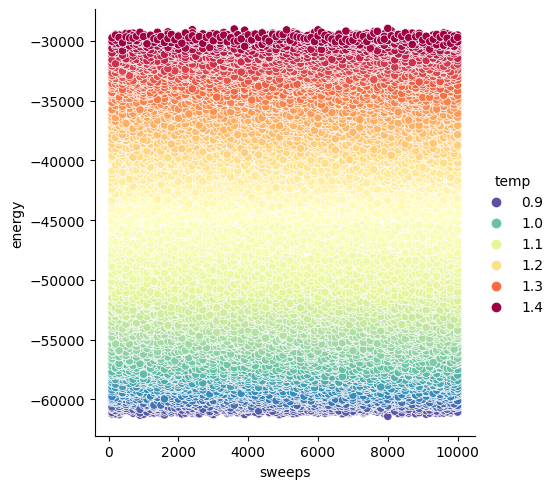

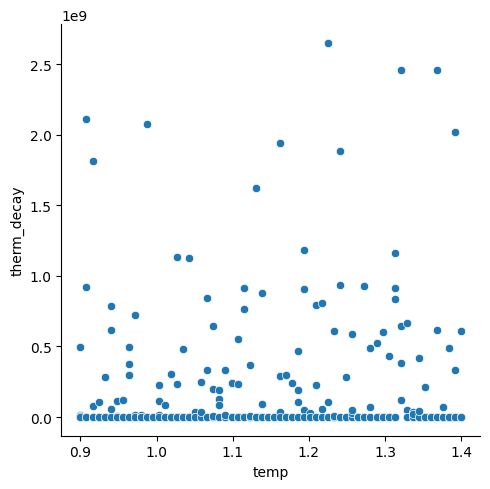

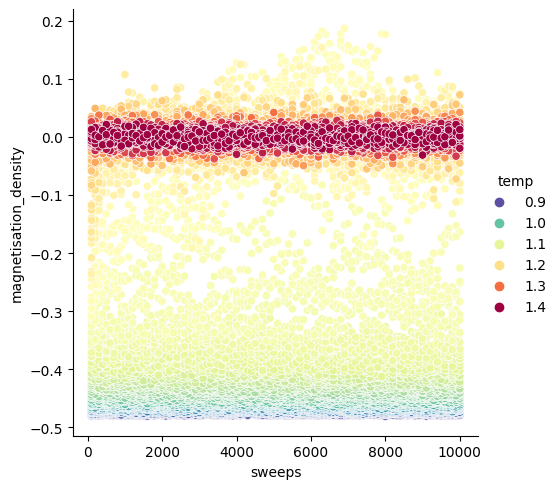

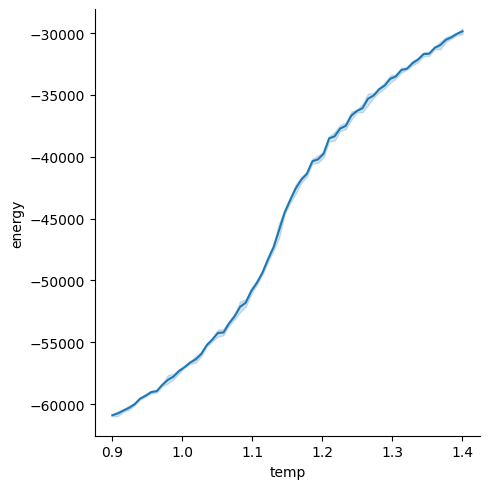

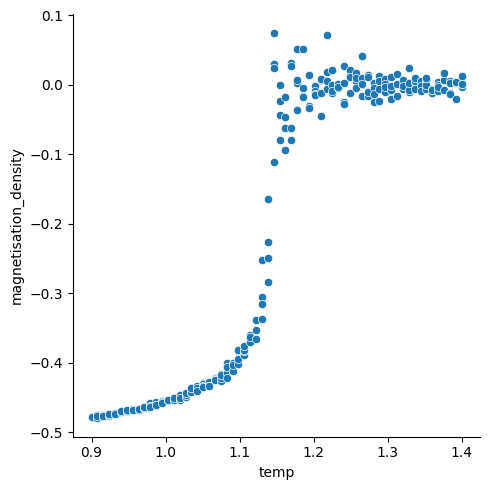

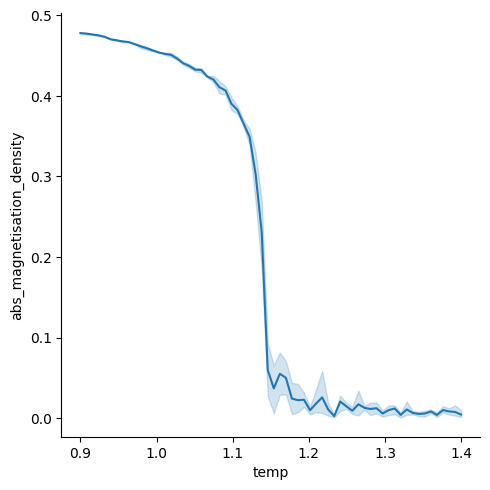

In [20]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_therm_fit = sns.relplot(
    data=evolve_meas_fit_df,
    x="temp",
    y="therm_decay",
)
fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [21]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [22]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

In [23]:
if not has_thermalised:
    raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [24]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function get_autocorrelation includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                        | 0/64000 [00:00<?, ?it/s]

  0%|                                            | 164/64000 [00:37<4:01:50,  4.40it/s]

  0%|▏                                           | 264/64000 [00:37<2:10:08,  8.16it/s]

  1%|▎                                             | 464/64000 [00:37<56:23, 18.78it/s]

  1%|▍                                             | 664/64000 [00:37<31:13, 33.80it/s]

  1%|▌                                             | 864/64000 [00:37<19:10, 54.89it/s]

  2%|▊                                            | 1164/64000 [00:38<10:36, 98.67it/s]

  2%|▉                                           | 1364/64000 [00:38<07:32, 138.50it/s]

  3%|█▎                                          | 1864/64000 [00:38<03:43, 278.11it/s]

  4%|█▋                                          | 2364/64000 [00:38<02:13, 462.67it/s]

  5%|██                                          | 2964/64000 [00:38<01:21, 749.99it/s]

  5%|██▎                                         | 3364/64000 [00:38<01:03, 952.16it/s]

  6%|██▋                                        | 3964/64000 [00:38<00:43, 1376.08it/s]

  7%|██▉                                        | 4364/64000 [00:38<00:35, 1660.05it/s]

  8%|███▍                                       | 5064/64000 [00:39<00:24, 2381.61it/s]

  9%|███▊                                       | 5664/64000 [00:39<00:20, 2906.64it/s]

 10%|████▏                                      | 6164/64000 [00:39<00:27, 2078.82it/s]

 10%|████▎                                      | 6464/64000 [00:51<00:27, 2078.82it/s]

 10%|████▌                                        | 6564/64000 [01:15<21:16, 45.00it/s]

 11%|████▊                                        | 6764/64000 [01:15<18:09, 52.55it/s]

 11%|█████                                        | 7164/64000 [01:16<13:00, 72.86it/s]

 12%|█████▏                                       | 7464/64000 [01:16<09:53, 95.29it/s]

 12%|█████▎                                      | 7764/64000 [01:16<07:37, 123.03it/s]

 13%|█████▊                                      | 8464/64000 [01:16<04:07, 224.22it/s]

 14%|██████▏                                     | 8964/64000 [01:16<02:51, 320.08it/s]

 15%|██████▍                                     | 9364/64000 [01:17<02:12, 413.24it/s]

 15%|██████▋                                     | 9664/64000 [01:17<01:46, 511.49it/s]

 16%|██████▊                                     | 9964/64000 [01:17<01:25, 633.34it/s]

 16%|██████▉                                    | 10264/64000 [01:17<01:08, 782.98it/s]

 17%|███████                                   | 10764/64000 [01:17<00:46, 1144.94it/s]

 17%|███████▎                                  | 11164/64000 [01:17<00:42, 1251.71it/s]

 18%|███████▌                                  | 11464/64000 [01:17<00:37, 1384.65it/s]

 19%|███████▊                                  | 11864/64000 [01:18<00:32, 1605.50it/s]

 19%|███████▉                                  | 12164/64000 [01:18<00:42, 1233.31it/s]

 19%|████████▏                                 | 12464/64000 [01:18<00:38, 1345.93it/s]

 20%|████████▎                                 | 12664/64000 [01:18<00:43, 1167.19it/s]

 20%|████████▋                                  | 12864/64000 [01:19<01:16, 670.73it/s]

 20%|████████▋                                  | 12864/64000 [01:31<01:16, 670.73it/s]

 20%|████████▉                                   | 12964/64000 [01:52<39:56, 21.29it/s]

 20%|████████▉                                   | 13064/64000 [01:53<34:21, 24.71it/s]

 21%|█████████                                   | 13164/64000 [01:53<28:00, 30.25it/s]

 21%|█████████                                   | 13264/64000 [01:53<22:26, 37.68it/s]

 21%|█████████▎                                  | 13464/64000 [01:53<14:02, 59.98it/s]

 21%|█████████▍                                  | 13664/64000 [01:54<09:34, 87.66it/s]

 22%|█████████▏                                 | 13764/64000 [01:54<07:52, 106.34it/s]

 22%|█████████▍                                 | 14064/64000 [01:54<04:29, 185.54it/s]

 22%|█████████▋                                 | 14364/64000 [01:54<02:54, 284.55it/s]

 23%|█████████▊                                 | 14664/64000 [01:55<01:58, 415.97it/s]

 23%|██████████                                 | 14964/64000 [01:55<01:24, 577.68it/s]

 24%|██████████▍                                | 15564/64000 [01:55<00:48, 999.03it/s]

 25%|██████████▍                               | 15864/64000 [01:55<00:47, 1020.39it/s]

 25%|██████████▌                               | 16164/64000 [01:55<00:40, 1175.74it/s]

 26%|███████████                                | 16464/64000 [01:56<00:48, 989.03it/s]

 26%|███████████                               | 16864/64000 [01:56<00:39, 1204.44it/s]

 27%|███████████▎                              | 17164/64000 [01:56<00:33, 1418.83it/s]

 27%|███████████▍                              | 17464/64000 [01:56<00:31, 1467.04it/s]

 28%|███████████▋                              | 17864/64000 [01:56<00:26, 1713.38it/s]

 29%|███████████▉                              | 18264/64000 [01:57<00:27, 1657.18it/s]

 29%|████████████                              | 18464/64000 [01:57<00:33, 1370.69it/s]

 29%|████████████▎                             | 18764/64000 [01:57<00:28, 1568.24it/s]

 30%|████████████▋                              | 18964/64000 [01:58<00:49, 907.56it/s]

 30%|████████████▉                              | 19164/64000 [01:58<01:07, 662.17it/s]

 30%|████████████▉                              | 19264/64000 [02:11<01:07, 662.17it/s]

 30%|█████████████▎                              | 19364/64000 [02:30<31:16, 23.78it/s]

 31%|█████████████▍                              | 19564/64000 [02:31<23:20, 31.73it/s]

 31%|█████████████▌                              | 19664/64000 [02:31<19:50, 37.24it/s]

 31%|█████████████▋                              | 19964/64000 [02:31<11:54, 61.63it/s]

 31%|█████████████▊                              | 20064/64000 [02:32<10:19, 70.92it/s]

 32%|█████████████▊                              | 20164/64000 [02:32<08:31, 85.76it/s]

 32%|█████████████▌                             | 20264/64000 [02:32<06:57, 104.74it/s]

 32%|█████████████▋                             | 20464/64000 [02:32<04:48, 150.71it/s]

 32%|█████████████▉                             | 20664/64000 [02:32<03:14, 222.75it/s]

 33%|██████████████                             | 20864/64000 [02:33<02:22, 302.85it/s]

 33%|██████████████▏                            | 21164/64000 [02:33<01:28, 484.05it/s]

 33%|██████████████▎                            | 21364/64000 [02:33<01:17, 553.51it/s]

 34%|██████████████▍                            | 21564/64000 [02:33<01:01, 694.70it/s]

 34%|██████████████▋                            | 21864/64000 [02:33<00:45, 933.38it/s]

 34%|██████████████▊                            | 22064/64000 [02:34<00:52, 795.48it/s]

 35%|██████████████▉                            | 22264/64000 [02:34<00:53, 777.61it/s]

 35%|███████████████                            | 22464/64000 [02:34<00:52, 796.75it/s]

 35%|███████████████▏                           | 22664/64000 [02:34<00:46, 896.27it/s]

 36%|███████████████▎                           | 22864/64000 [02:34<00:41, 981.21it/s]

 36%|███████████████▏                          | 23164/64000 [02:34<00:31, 1295.38it/s]

 37%|███████████████▎                          | 23364/64000 [02:35<00:34, 1166.47it/s]

 37%|███████████████▌                          | 23664/64000 [02:35<00:30, 1330.94it/s]

 37%|███████████████▋                          | 23864/64000 [02:35<00:32, 1253.87it/s]

 38%|███████████████▊                          | 24064/64000 [02:35<00:32, 1233.48it/s]

 38%|███████████████▉                          | 24264/64000 [02:35<00:35, 1128.98it/s]

 38%|████████████████                          | 24464/64000 [02:36<00:30, 1283.45it/s]

 39%|████████████████▎                         | 24764/64000 [02:36<00:25, 1529.27it/s]

 39%|████████████████▍                         | 24964/64000 [02:36<00:37, 1049.69it/s]

 39%|████████████████▌                         | 25164/64000 [02:36<00:34, 1119.96it/s]

 40%|█████████████████                          | 25364/64000 [02:37<01:08, 561.46it/s]

 40%|█████████████████▏                         | 25564/64000 [02:37<00:58, 651.49it/s]

 40%|█████████████████▏                         | 25664/64000 [02:51<00:58, 651.49it/s]

 40%|█████████████████▋                          | 25764/64000 [03:08<29:00, 21.96it/s]

 40%|█████████████████▊                          | 25864/64000 [03:09<25:04, 25.34it/s]

 41%|█████████████████▊                          | 25964/64000 [03:09<20:34, 30.82it/s]

 41%|█████████████████▉                          | 26164/64000 [03:09<13:14, 47.62it/s]

 41%|██████████████████                          | 26264/64000 [03:09<10:46, 58.41it/s]

 41%|██████████████████▏                         | 26464/64000 [03:10<06:55, 90.27it/s]

 42%|█████████████████▊                         | 26564/64000 [03:10<05:53, 105.93it/s]

 42%|█████████████████▉                         | 26664/64000 [03:10<04:46, 130.44it/s]

 42%|█████████████████▉                         | 26764/64000 [03:10<03:45, 164.78it/s]

 42%|██████████████████                         | 26864/64000 [03:10<03:03, 202.40it/s]

 42%|██████████████████                         | 26964/64000 [03:11<02:25, 254.96it/s]

 42%|██████████████████▏                        | 27064/64000 [03:11<02:05, 293.59it/s]

 43%|██████████████████▍                        | 27364/64000 [03:11<01:14, 492.49it/s]

 43%|██████████████████▌                        | 27664/64000 [03:11<00:47, 772.10it/s]

 44%|██████████████████▋                        | 27864/64000 [03:12<00:54, 662.57it/s]

 44%|██████████████████▊                        | 28064/64000 [03:12<00:45, 785.45it/s]

 44%|██████████████████▉                        | 28264/64000 [03:12<00:38, 934.60it/s]

 44%|███████████████████                        | 28464/64000 [03:12<00:45, 773.31it/s]

 45%|███████████████████▎                       | 28664/64000 [03:12<00:40, 880.19it/s]

 45%|███████████████████▍                       | 28864/64000 [03:13<00:39, 895.33it/s]

 45%|███████████████████▌                       | 29064/64000 [03:13<00:40, 863.50it/s]

 46%|███████████████████▊                       | 29464/64000 [03:13<00:40, 859.32it/s]

 46%|███████████████████▉                       | 29664/64000 [03:13<00:36, 929.25it/s]

 47%|███████████████████▋                      | 30064/64000 [03:14<00:26, 1280.52it/s]

 47%|███████████████████▊                      | 30264/64000 [03:14<00:27, 1232.48it/s]

 48%|████████████████████                      | 30664/64000 [03:14<00:21, 1580.04it/s]

 48%|████████████████████▎                     | 30864/64000 [03:14<00:22, 1474.08it/s]

 49%|████████████████████▍                     | 31164/64000 [03:14<00:19, 1715.40it/s]

 49%|█████████████████████                      | 31364/64000 [03:15<00:36, 905.49it/s]

 49%|█████████████████████▏                     | 31564/64000 [03:16<01:01, 529.98it/s]

 50%|█████████████████████▎                     | 31764/64000 [03:16<01:03, 507.41it/s]

 50%|█████████████████████▍                     | 31864/64000 [03:16<01:02, 511.91it/s]

 50%|█████████████████████▌                     | 32064/64000 [03:17<01:02, 507.81it/s]

 50%|█████████████████████▌                     | 32064/64000 [03:31<01:02, 507.81it/s]

 50%|██████████████████████                      | 32164/64000 [03:45<28:33, 18.58it/s]

 50%|██████████████████████▏                     | 32264/64000 [03:46<23:48, 22.22it/s]

 51%|██████████████████████▎                     | 32364/64000 [03:47<18:35, 28.35it/s]

 51%|██████████████████████▎                     | 32464/64000 [03:47<14:22, 36.56it/s]

 51%|██████████████████████▍                     | 32564/64000 [03:48<11:41, 44.84it/s]

 51%|██████████████████████▌                     | 32864/64000 [03:48<05:45, 90.05it/s]

 52%|██████████████████████▏                    | 32964/64000 [03:48<04:47, 108.04it/s]

 52%|██████████████████████▏                    | 33064/64000 [03:49<04:11, 123.04it/s]

 52%|██████████████████████▎                    | 33264/64000 [03:49<02:50, 179.83it/s]

 52%|██████████████████████▍                    | 33364/64000 [03:49<02:27, 208.02it/s]

 52%|██████████████████████▌                    | 33564/64000 [03:49<01:38, 310.11it/s]

 53%|██████████████████████▋                    | 33764/64000 [03:50<01:20, 374.08it/s]

 53%|██████████████████████▊                    | 33864/64000 [03:50<01:10, 424.92it/s]

 53%|██████████████████████▉                    | 34164/64000 [03:50<00:47, 623.66it/s]

 54%|███████████████████████                    | 34364/64000 [03:50<00:47, 620.87it/s]

 54%|███████████████████████▏                   | 34564/64000 [03:50<00:40, 727.40it/s]

 54%|███████████████████████▎                   | 34764/64000 [03:51<00:34, 858.40it/s]

 55%|███████████████████████▍                   | 34964/64000 [03:51<00:33, 872.72it/s]

 55%|███████████████████████▏                  | 35264/64000 [03:51<00:27, 1053.13it/s]

 55%|███████████████████████▎                  | 35464/64000 [03:51<00:27, 1025.35it/s]

 56%|███████████████████████▍                  | 35664/64000 [03:51<00:24, 1147.88it/s]

 56%|███████████████████████▌                  | 35864/64000 [03:52<00:27, 1024.86it/s]

 56%|████████████████████████▏                  | 36064/64000 [03:52<00:29, 946.63it/s]

 57%|███████████████████████▊                  | 36264/64000 [03:52<00:26, 1042.27it/s]

 58%|████████████████████████▏                 | 36864/64000 [03:52<00:14, 1909.34it/s]

 58%|████████████████████████▍                 | 37164/64000 [03:52<00:21, 1252.12it/s]

 58%|████████████████████████▌                 | 37364/64000 [03:53<00:24, 1105.72it/s]

 59%|█████████████████████████▏                 | 37564/64000 [03:53<00:27, 969.59it/s]

 59%|█████████████████████████▎                 | 37764/64000 [03:53<00:33, 793.50it/s]

 59%|█████████████████████████▌                 | 37964/64000 [03:54<00:37, 688.70it/s]

 59%|█████████████████████████▌                 | 38064/64000 [03:54<00:54, 472.03it/s]

 60%|█████████████████████████▋                 | 38164/64000 [03:55<01:18, 328.77it/s]

 60%|█████████████████████████▋                 | 38264/64000 [03:55<01:16, 334.24it/s]

 60%|█████████████████████████▊                 | 38364/64000 [03:56<01:07, 379.38it/s]

 60%|█████████████████████████▊                 | 38464/64000 [03:56<01:04, 394.64it/s]

 60%|█████████████████████████▊                 | 38464/64000 [04:11<01:04, 394.64it/s]

 60%|██████████████████████████▌                 | 38564/64000 [04:24<31:30, 13.46it/s]

 60%|██████████████████████████▌                 | 38664/64000 [04:25<24:11, 17.45it/s]

 61%|██████████████████████████▋                 | 38864/64000 [04:25<13:39, 30.66it/s]

 61%|██████████████████████████▊                 | 38964/64000 [04:26<11:17, 36.97it/s]

 61%|██████████████████████████▊                 | 39064/64000 [04:26<08:33, 48.60it/s]

 61%|██████████████████████████▉                 | 39164/64000 [04:26<06:26, 64.33it/s]

 62%|██████████████████████████▌                | 39464/64000 [04:27<03:29, 117.07it/s]

 62%|██████████████████████████▋                | 39664/64000 [04:27<02:26, 166.52it/s]

 62%|██████████████████████████▋                | 39764/64000 [04:27<02:09, 187.81it/s]

 62%|██████████████████████████▊                | 39864/64000 [04:27<01:52, 213.80it/s]

 62%|██████████████████████████▊                | 39964/64000 [04:28<01:31, 261.26it/s]

 63%|██████████████████████████▉                | 40164/64000 [04:28<01:11, 335.49it/s]

 63%|███████████████████████████▏               | 40464/64000 [04:28<00:45, 514.32it/s]

 63%|███████████████████████████▎               | 40564/64000 [04:28<00:48, 484.89it/s]

 64%|███████████████████████████▎               | 40664/64000 [04:29<00:43, 539.68it/s]

 64%|███████████████████████████▍               | 40764/64000 [04:29<00:42, 544.73it/s]

 64%|███████████████████████████▌               | 41064/64000 [04:29<00:26, 853.44it/s]

 65%|███████████████████████████▊               | 41364/64000 [04:29<00:24, 915.74it/s]

 65%|███████████████████████████▉               | 41564/64000 [04:29<00:25, 882.76it/s]

 65%|████████████████████████████               | 41764/64000 [04:30<00:27, 808.16it/s]

 66%|████████████████████████████▏              | 41964/64000 [04:30<00:23, 934.56it/s]

 66%|███████████████████████████▋              | 42264/64000 [04:30<00:18, 1169.14it/s]

 66%|████████████████████████████▌              | 42464/64000 [04:30<00:23, 911.53it/s]

 67%|████████████████████████████▋              | 42664/64000 [04:31<00:23, 914.94it/s]

 67%|████████████████████████████▏             | 42964/64000 [04:31<00:17, 1192.41it/s]

 68%|████████████████████████████▍             | 43264/64000 [04:31<00:18, 1115.14it/s]

 68%|████████████████████████████▌             | 43464/64000 [04:31<00:19, 1063.09it/s]

 68%|████████████████████████████▋             | 43664/64000 [04:31<00:17, 1174.81it/s]

 69%|█████████████████████████████▍             | 43864/64000 [04:32<00:21, 929.01it/s]

 69%|█████████████████████████████▌             | 44064/64000 [04:32<00:22, 895.77it/s]

 69%|█████████████████████████████▋             | 44264/64000 [04:33<00:34, 575.59it/s]

 69%|█████████████████████████████▊             | 44364/64000 [04:33<00:32, 603.98it/s]

 69%|█████████████████████████████▊             | 44464/64000 [04:33<00:45, 429.61it/s]

 70%|█████████████████████████████▉             | 44564/64000 [04:33<00:41, 470.90it/s]

 70%|██████████████████████████████             | 44664/64000 [04:34<00:50, 382.64it/s]

 70%|██████████████████████████████             | 44764/64000 [04:35<01:16, 252.23it/s]

 70%|██████████████████████████████▏            | 44864/64000 [04:51<01:15, 252.23it/s]

 70%|██████████████████████████████▉             | 44964/64000 [05:01<18:29, 17.15it/s]

 70%|██████████████████████████████▉             | 45064/64000 [05:03<15:30, 20.35it/s]

 71%|███████████████████████████████             | 45264/64000 [05:03<09:22, 33.32it/s]

 71%|███████████████████████████████▏            | 45364/64000 [05:03<07:24, 41.96it/s]

 71%|███████████████████████████████▎            | 45464/64000 [05:04<05:41, 54.27it/s]

 71%|███████████████████████████████▎            | 45564/64000 [05:04<04:54, 62.61it/s]

 72%|██████████████████████████████▋            | 45764/64000 [05:05<02:54, 104.77it/s]

 72%|██████████████████████████████▊            | 45864/64000 [05:05<02:18, 131.11it/s]

 72%|██████████████████████████████▉            | 45964/64000 [05:05<01:50, 163.34it/s]

 72%|███████████████████████████████            | 46164/64000 [05:06<01:31, 194.30it/s]

 72%|███████████████████████████████            | 46264/64000 [05:06<01:18, 225.91it/s]

 73%|███████████████████████████████▎           | 46564/64000 [05:06<00:45, 379.13it/s]

 73%|███████████████████████████████▎           | 46664/64000 [05:06<00:48, 361.16it/s]

 73%|███████████████████████████████▍           | 46764/64000 [05:07<00:42, 406.42it/s]

 73%|███████████████████████████████▌           | 46964/64000 [05:07<00:30, 559.29it/s]

 74%|███████████████████████████████▋           | 47164/64000 [05:07<00:25, 650.84it/s]

 74%|███████████████████████████████▉           | 47464/64000 [05:07<00:17, 945.08it/s]

 74%|████████████████████████████████           | 47664/64000 [05:08<00:26, 624.23it/s]

 75%|████████████████████████████████▏          | 47864/64000 [05:08<00:26, 617.21it/s]

 75%|████████████████████████████████▏          | 47964/64000 [05:08<00:28, 568.42it/s]

 75%|████████████████████████████████▎          | 48064/64000 [05:08<00:26, 603.38it/s]

 75%|████████████████████████████████▎          | 48164/64000 [05:08<00:25, 632.40it/s]

 76%|████████████████████████████████▍          | 48364/64000 [05:09<00:18, 845.10it/s]

 76%|███████████████████████████████▊          | 48564/64000 [05:09<00:15, 1027.65it/s]

 76%|████████████████████████████████▊          | 48764/64000 [05:09<00:15, 967.84it/s]

 77%|████████████████████████████████▉          | 48964/64000 [05:09<00:15, 984.05it/s]

 77%|████████████████████████████████▎         | 49164/64000 [05:09<00:13, 1088.22it/s]

 77%|████████████████████████████████▍         | 49364/64000 [05:09<00:13, 1096.06it/s]

 78%|████████████████████████████████▌         | 49664/64000 [05:10<00:11, 1297.15it/s]

 78%|████████████████████████████████▋         | 49864/64000 [05:10<00:11, 1274.19it/s]

 78%|████████████████████████████████▊         | 50064/64000 [05:10<00:13, 1048.25it/s]

 79%|█████████████████████████████████▊         | 50264/64000 [05:10<00:17, 774.29it/s]

 79%|█████████████████████████████████▉         | 50464/64000 [05:11<00:15, 899.74it/s]

 79%|██████████████████████████████████         | 50664/64000 [05:11<00:19, 700.85it/s]

 79%|██████████████████████████████████         | 50764/64000 [05:11<00:18, 724.68it/s]

 79%|██████████████████████████████████▏        | 50864/64000 [05:11<00:19, 670.68it/s]

 80%|██████████████████████████████████▏        | 50964/64000 [05:12<00:46, 280.41it/s]

 80%|██████████████████████████████████▎        | 51064/64000 [05:13<00:41, 310.19it/s]

 80%|██████████████████████████████████▍        | 51164/64000 [05:13<00:44, 285.96it/s]

 80%|██████████████████████████████████▍        | 51264/64000 [05:13<00:45, 281.73it/s]

 80%|██████████████████████████████████▍        | 51264/64000 [05:31<00:45, 281.73it/s]

 80%|███████████████████████████████████▎        | 51364/64000 [05:40<15:48, 13.33it/s]

 80%|███████████████████████████████████▍        | 51463/64000 [05:40<11:29, 18.20it/s]

 81%|███████████████████████████████████▍        | 51563/64000 [05:40<08:21, 24.82it/s]

 81%|███████████████████████████████████▌        | 51662/64000 [05:41<06:04, 33.86it/s]

 81%|███████████████████████████████████▌        | 51762/64000 [05:41<04:36, 44.27it/s]

 81%|███████████████████████████████████▋        | 51962/64000 [05:42<02:31, 79.66it/s]

 81%|██████████████████████████████████▉        | 52062/64000 [05:42<01:58, 100.90it/s]

 82%|███████████████████████████████████        | 52260/64000 [05:42<01:13, 158.91it/s]

 82%|███████████████████████████████████▏       | 52458/64000 [05:42<00:49, 235.26it/s]

 82%|███████████████████████████████████▎       | 52558/64000 [05:42<00:46, 244.44it/s]

 82%|███████████████████████████████████▍       | 52658/64000 [05:43<00:38, 291.29it/s]

 82%|███████████████████████████████████▍       | 52758/64000 [05:43<00:36, 308.47it/s]

 83%|███████████████████████████████████▋       | 53056/64000 [05:43<00:20, 540.28it/s]

 83%|███████████████████████████████████▊       | 53255/64000 [05:43<00:16, 633.07it/s]

 84%|███████████████████████████████████▉       | 53454/64000 [05:43<00:16, 650.34it/s]

 84%|████████████████████████████████████       | 53653/64000 [05:44<00:13, 762.70it/s]

 84%|████████████████████████████████████▏      | 53852/64000 [05:44<00:12, 781.33it/s]

 84%|████████████████████████████████████▏      | 53951/64000 [05:44<00:14, 699.71it/s]

 84%|████████████████████████████████████▎      | 54050/64000 [05:44<00:14, 709.47it/s]

 85%|████████████████████████████████████▍      | 54250/64000 [05:45<00:15, 634.29it/s]

 85%|███████████████████████████████████▊      | 54649/64000 [05:45<00:08, 1074.27it/s]

 86%|███████████████████████████████████▉      | 54847/64000 [05:45<00:09, 1011.59it/s]

 86%|████████████████████████████████████▏     | 55145/64000 [05:45<00:06, 1286.07it/s]

 86%|█████████████████████████████████████▏     | 55344/64000 [05:45<00:08, 999.05it/s]

 87%|█████████████████████████████████████▎     | 55543/64000 [05:46<00:08, 978.75it/s]

 87%|█████████████████████████████████████▍     | 55743/64000 [05:46<00:08, 935.57it/s]

 88%|████████████████████████████████████▊     | 56141/64000 [05:46<00:05, 1332.21it/s]

 88%|████████████████████████████████████▉     | 56340/64000 [05:46<00:06, 1268.55it/s]

 88%|█████████████████████████████████████▏    | 56639/64000 [05:46<00:04, 1564.03it/s]

 89%|█████████████████████████████████████▎    | 56837/64000 [05:47<00:05, 1225.56it/s]

 89%|█████████████████████████████████████▍    | 57035/64000 [05:47<00:05, 1238.69it/s]

 89%|█████████████████████████████████████▌    | 57235/64000 [05:47<00:06, 1097.21it/s]

 90%|█████████████████████████████████████▋    | 57435/64000 [05:47<00:05, 1212.63it/s]

 90%|█████████████████████████████████████▊    | 57634/64000 [05:47<00:04, 1276.00it/s]

 91%|██████████████████████████████████████    | 57933/64000 [05:47<00:03, 1548.63it/s]

 91%|██████████████████████████████████████▏   | 58132/64000 [05:47<00:03, 1597.37it/s]

 91%|██████████████████████████████████████▍   | 58529/64000 [05:48<00:03, 1682.62it/s]

 92%|██████████████████████████████████████▌   | 58827/64000 [05:48<00:02, 1850.00it/s]

 92%|██████████████████████████████████████▋   | 59026/64000 [05:48<00:03, 1586.48it/s]

 93%|██████████████████████████████████████▉   | 59325/64000 [05:48<00:02, 1785.09it/s]

 93%|███████████████████████████████████████   | 59525/64000 [05:48<00:02, 1614.26it/s]

 93%|███████████████████████████████████████▎  | 59823/64000 [05:48<00:02, 1897.84it/s]

 94%|███████████████████████████████████████▍  | 60122/64000 [05:49<00:02, 1793.86it/s]

 95%|███████████████████████████████████████▋  | 60519/64000 [05:49<00:01, 1991.30it/s]

 95%|███████████████████████████████████████▉  | 60817/64000 [05:49<00:01, 2106.53it/s]

 95%|████████████████████████████████████████  | 61116/64000 [05:49<00:01, 1947.66it/s]

 96%|████████████████████████████████████████▎ | 61415/64000 [05:49<00:01, 1863.47it/s]

 96%|████████████████████████████████████████▍ | 61614/64000 [05:49<00:01, 1689.79it/s]

 97%|████████████████████████████████████████▋ | 61911/64000 [05:50<00:01, 1637.53it/s]

 97%|████████████████████████████████████████▊ | 62210/64000 [05:50<00:01, 1585.42it/s]

 98%|████████████████████████████████████████▉ | 62409/64000 [05:50<00:01, 1496.90it/s]

 98%|█████████████████████████████████████████ | 62608/64000 [05:50<00:01, 1355.14it/s]

 98%|█████████████████████████████████████████▏| 62807/64000 [05:50<00:00, 1349.32it/s]

 98%|█████████████████████████████████████████▎| 63006/64000 [05:50<00:00, 1148.39it/s]

 99%|█████████████████████████████████████████▍| 63204/64000 [05:51<00:00, 1064.88it/s]

 99%|██████████████████████████████████████████▌| 63403/64000 [05:51<00:00, 767.55it/s]

 99%|██████████████████████████████████████████▋| 63503/64000 [05:52<00:00, 536.26it/s]

 99%|██████████████████████████████████████████▋| 63602/64000 [05:52<00:00, 423.37it/s]

100%|██████████████████████████████████████████▊| 63702/64000 [05:52<00:00, 417.82it/s]

100%|██████████████████████████████████████████▊| 63802/64000 [05:52<00:00, 419.33it/s]

100%|██████████████████████████████████████████▉| 63901/64000 [05:53<00:00, 462.64it/s]

100%|███████████████████████████████████████████| 64000/64000 [05:53<00:00, 414.04it/s]

100%|███████████████████████████████████████████| 64000/64000 [06:11<00:00, 414.04it/s]

2023-04-25 16:30:18.629931: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=15, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:20.353100: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=20, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:20.555979: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=21, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:20.943687: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=27, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:21.004367: E external/xla/xla/service/collective_ops_

2023-04-25 16:30:21.206850: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=14, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:21.229518: E external/xla/xla/service/collective_ops_

2023-04-25 16:30:21.791381: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:21.826548: E external/xla/xla/service/collective_ops_u

2023-04-25 16:30:22.008453: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=22, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:22.038157: E external/xla/xla/service/collective_ops_

2023-04-25 16:30:22.367939: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=7, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:22.849488: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=49, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:23.160708: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=6, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}


2023-04-25 16:30:23.482766: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=51, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:23.534609: E external/xla/xla/service/collective_ops_

2023-04-25 16:30:23.737831: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=16777216}], rendezvous_key=RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}, device_ordinal=44, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1669, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=40}
2023-04-25 16:30:23.887880: E external/xla/xla/service/collective_ops_

Ran autocorrelation program in: 413.8996171951294 sec.


In [25]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,state.model.interaction_biquadratic,state.model.interaction_anisotropy,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.id_,state.steps,state.sweeps,temp
0,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.1065369, -0.017595638, 0.04190951, 0.0...","[1.0, 0.14509803, 0.016692182, 0.059931524, 0....",0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,0,786432000,12000,0.900000
1,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.06856059, -0.0063817087, -0.03315695, ...","[1.0, 0.14893173, 0.01736922, -0.030744784, -0...",2.000000,1.049675,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,1,786432000,12000,0.900000
2,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.14567922, -0.012442529, -0.009781328, ...","[1.0, 0.21550103, 0.046784654, 0.016216842, -0...",1.037729,1.303266,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,2,786432000,12000,0.900000
3,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.14452359, 0.053091887, -0.01700611, 0....","[1.0, 0.22670864, 0.08333444, -0.0084509915, 0...",1.038493,1.356229,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,3,786432000,12000,0.900000
4,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.100285105, 0.020752378, 0.020117665, -...","[1.0, 0.1687476, 0.039266862, 0.0048350627, -0...",0.869463,1.124743,1.101399,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,4,786432000,12000,0.907937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.27359584, 0.1082932, 0.11228728, 0.056...","[1.0, 0.43372744, 0.17483832, 0.046895623, 0.0...",1.571167,2.381681,0.718358,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,251,786432000,12000,1.392063
252,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.21477295, 0.12529851, -0.010975597, -0...","[1.0, 0.37731376, 0.17570011, 0.06606587, -8.4...",1.345396,2.080146,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,252,786432000,12000,1.400000
253,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.28081805, 0.06654285, 0.025429958, 0.0...","[1.0, 0.45478904, 0.20337081, 0.1053577, 0.026...",1.573297,2.536314,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,253,786432000,12000,1.400000
254,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.22972055, 0.08612517, 0.063192405, 0.0...","[1.0, 0.415311, 0.23380215, 0.13927023, 0.1031...",1.372921,2.393703,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,254,786432000,12000,1.400000


,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,...,state.model.interaction_anisotropy,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.id_,state.steps,state.sweeps,temp,energy_fit,mag_dens_fit
0,1000,2,0,1.000000,1.000000,0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,0,786432000,12000,0.9,1.000000e+00,1.000000e+00
0,1000,2,2,0.106537,0.145098,0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,0,786432000,12000,0.9,1.067660e-01,1.456653e-01
0,1000,2,4,-0.017596,0.016692,0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,0,786432000,12000,0.9,1.139898e-02,2.121837e-02
0,1000,2,6,0.041910,0.059932,0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,0,786432000,12000,0.9,1.217023e-03,3.090779e-03
0,1000,2,8,0.022360,0.022963,0.894008,1.038182,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,0,786432000,12000,0.9,1.299366e-04,4.502192e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1000,2,52,-0.017964,0.051563,1.764271,2.655885,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,255,786432000,12000,1.4,1.583552e-13,3.139624e-09
255,1000,2,54,-0.034268,0.056670,1.764271,2.655885,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,255,786432000,12000,1.4,5.096952e-14,1.478545e-09
255,1000,2,56,0.030053,0.060443,1.764271,2.655885,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,255,786432000,12000,1.4,1.640547e-14,6.962918e-10
255,1000,2,58,0.023236,0.021848,1.764271,2.655885,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,0.0,1.0,255,786432000,12000,1.4,5.280401e-15,3.279050e-10


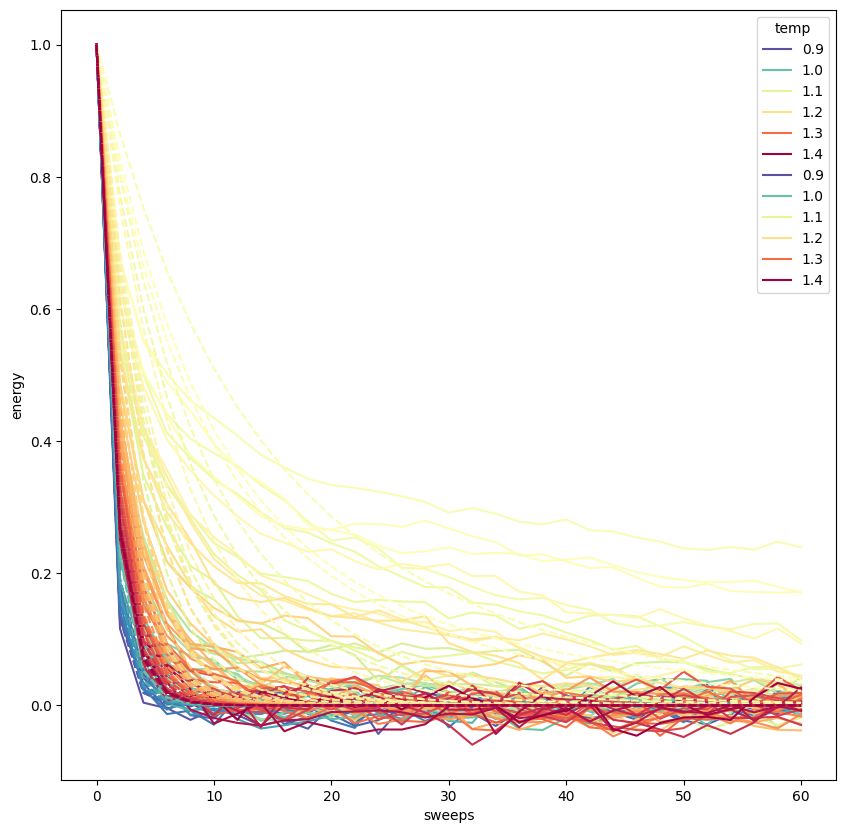

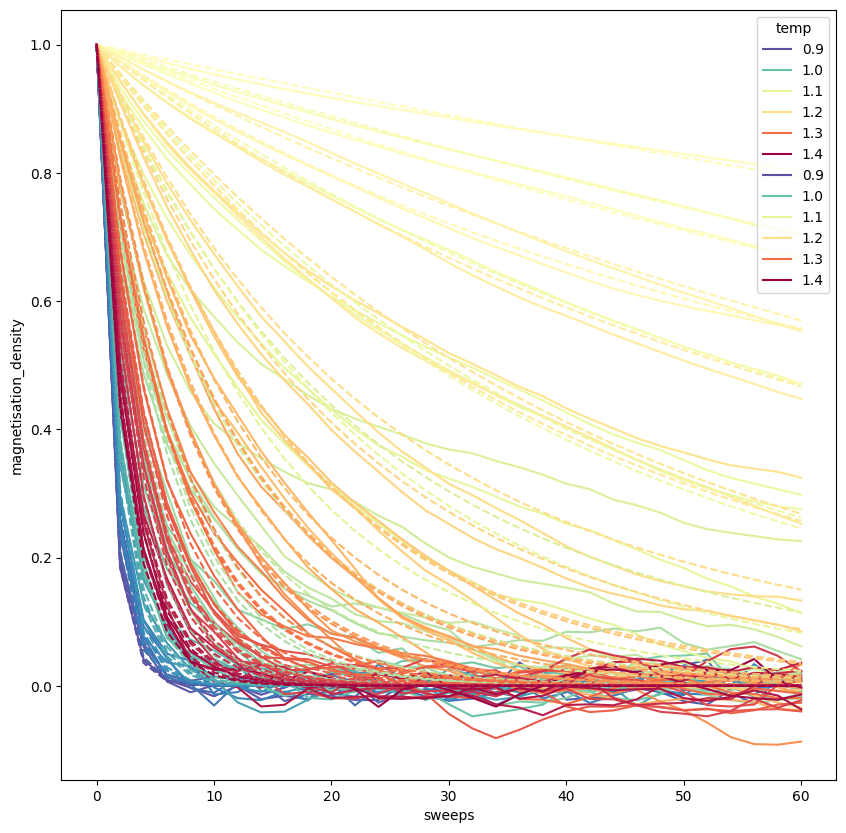

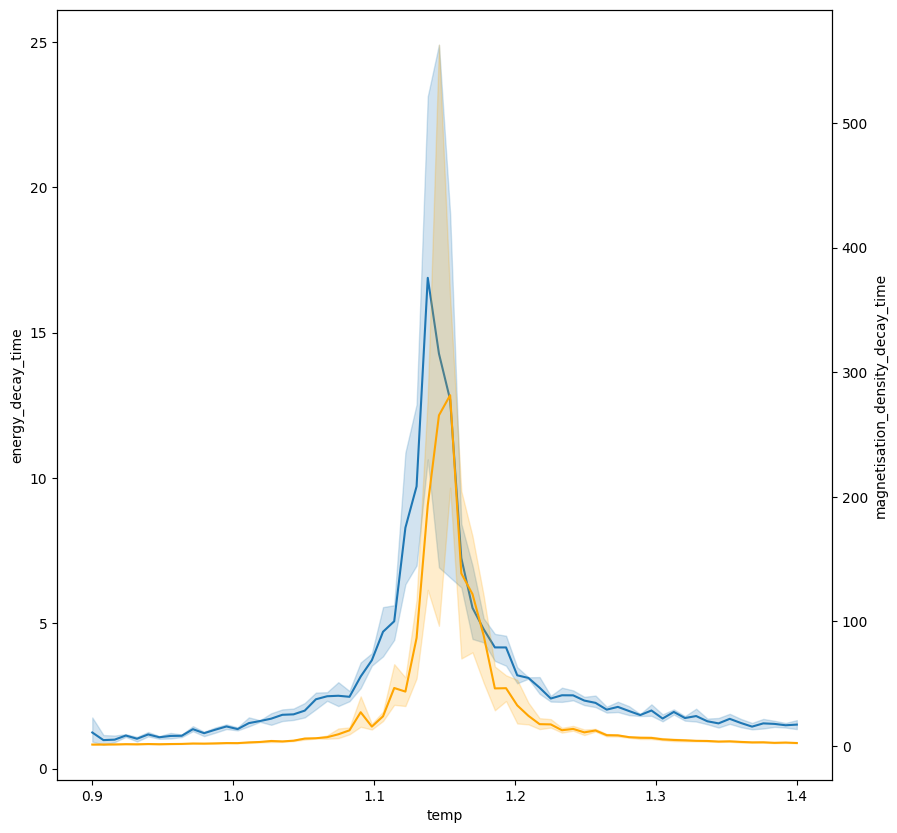

In [26]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [27]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        5,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

In [28]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [29]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    from scipy import constants

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

In [30]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

In [31]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

In [32]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [33]:
to_save |= c.dict()

with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )